In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from mlsmote import MLSMOTE

import tensorflow as tf
from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
FILE_PATH='data/riasec/labeled-data.csv'
EXCEPTION_SCORES=[0, 8, 16, 32]
THRESHOLD=0.2
EPOCHS=100
BATCH_SIZE=128
INPUT_SHAPE=48
OUTPUT_SHAPE=6

In [23]:
df = pd.read_csv(FILE_PATH)
# df = df[~(
#     (df['R_Score'].isin(EXCEPTION_SCORES)) & 
#     (df['I_Score'].isin(EXCEPTION_SCORES)) & 
#     (df['A_Score'].isin(EXCEPTION_SCORES)) & 
#     (df['S_Score'].isin(EXCEPTION_SCORES)) & 
#     (df['E_Score'].isin(EXCEPTION_SCORES)) & 
#     (df['C_Score'].isin(EXCEPTION_SCORES))
# )]

In [4]:
print(df.columns)

Index(['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'I1', 'I2', 'I3', 'I4',
       'I5', 'I6', 'I7', 'I8', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8',
       'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'E1', 'E2', 'E3', 'E4',
       'E5', 'E6', 'E7', 'E8', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'R_Score', 'I_Score', 'A_Score', 'S_Score', 'E_Score', 'C_Score',
       'R_Prob', 'I_Prob', 'A_Prob', 'S_Prob', 'E_Prob', 'C_Prob'],
      dtype='object')


In [24]:
feature_columns = [f'{col}{i}' for col in 'RIASEC' for i in range(1, 9)]
x = df[feature_columns]

label_columns = ['R_Prob','I_Prob','A_Prob','S_Prob','E_Prob','C_Prob']
y = pd.get_dummies(df[label_columns].idxmax(axis=1)).astype(int)
y = y.reindex(columns=label_columns, fill_value=0)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Data training shape\t: {x_train.shape[:]}")
print(f"Data testing shape\t: {x_test.shape[:]}")
print(f"Label training shape\t: {y_train.shape[:]}")
print(f"Label testing shape\t: {y_test.shape[:]}")

print(f"\nData training sample\t:\n,{x_train.head()}")
print(f"\nLabel training sample\t:\n,{y_train.head()}")

Data training shape	: (108611, 48)
Data testing shape	: (27153, 48)
Label training shape	: (108611, 6)
Label testing shape	: (27153, 6)

Data training sample	:
,        R1  R2  R3  R4  R5  R6  R7  R8  I1  I2  ...  E7  E8  C1  C2  C3  C4  \
22808    0   0   0   2   0   0   0   0   3   3  ...   0   3   0   0   0   1   
83359    2   3   3   2   1   3   2   2   3   4  ...   2   4   2   4   3   1   
68299    0   0   0   0   0   0   0   0   0   1  ...   0   4   0   0   0   0   
110292   2   1   0   1   0   0   1   2   4   4  ...   2   3   3   4   1   2   
89050    0   0   0   0   0   1   0   0   3   0  ...   2   1   0   0   1   1   

        C5  C6  C7  C8  
22808    0   0   0   0  
83359    3   3   2   2  
68299    0   2   0   0  
110292   1   4   1   2  
89050    1   1   1   0  

[5 rows x 48 columns]

Label training sample	:
,        R_Prob  I_Prob  A_Prob  S_Prob  E_Prob  C_Prob
22808        0       1       0       0       0       0
83359        0       0       1       0       0       0


In [ ]:
# def f1_score(y_true, y_pred):
#     y_pred_classes = K.round(y_pred)
#     tp = K.sum(K.cast(y_true * y_pred_classes, 'float'), axis=0)
#     fp = K.sum(K.cast((1 - y_true) * y_pred_classes, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true * (1 - y_pred_classes), 'float'), axis=0)

#     precision = tp / (tp + fp + K.epsilon())
#     recall = tp / (tp + fn + K.epsilon())
#     f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
#     return K.mean(f1)

In [72]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(INPUT_SHAPE,)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005), name='dense_layer_1'),
    tf.keras.layers.Dropout(0.3, name='dropout_layer_1'),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0005), name='dense_layer_2'),
    tf.keras.layers.Dropout(0.2, name='dropout_layer_2'),
    tf.keras.layers.Dense(OUTPUT_SHAPE, activation='softmax', name='output_layer')
])

In [73]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer_1 (Dense)       (None, 128)               6272      
                                                                 
 dropout_layer_1 (Dropout)   (None, 128)               0         
                                                                 
 dense_layer_2 (Dense)       (None, 64)                8256      
                                                                 
 dropout_layer_2 (Dropout)   (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 14918 (58.27 KB)
Trainable params: 14918 (58.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [75]:
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test), verbose=1)

Epoch 1/50
849/849 [==============================] - 3s 3ms/step - loss: 1.1885 - accuracy: 0.5794 - val_loss: 0.5383 - val_accuracy: 0.8563
Epoch 2/50
849/849 [==============================] - 3s 3ms/step - loss: 0.6467 - accuracy: 0.7781 - val_loss: 0.3863 - val_accuracy: 0.9016
Epoch 3/50
849/849 [==============================] - 2s 3ms/step - loss: 0.5247 - accuracy: 0.8231 - val_loss: 0.3214 - val_accuracy: 0.9265
Epoch 4/50
849/849 [==============================] - 3s 3ms/step - loss: 0.4649 - accuracy: 0.8454 - val_loss: 0.2835 - val_accuracy: 0.9390
Epoch 5/50
849/849 [==============================] - 4s 5ms/step - loss: 0.4247 - accuracy: 0.8617 - val_loss: 0.2603 - val_accuracy: 0.9472
Epoch 6/50
849/849 [==============================] - 3s 4ms/step - loss: 0.3982 - accuracy: 0.8712 - val_loss: 0.2423 - val_accuracy: 0.9526
Epoch 7/50
849/849 [==============================] - 3s 3ms/step - loss: 0.3688 - accuracy: 0.8825 - val_loss: 0.2270 - val_accuracy: 0.9585
Epoch 

In [76]:
results = model.evaluate(x_test, y_test)
print(f"Loss: {results[0]}, Accuracy: {results[1]}")

849/849 [==============================] - 1s 1ms/step - loss: 0.1028 - accuracy: 0.9930
Loss: 0.10278352349996567, Accuracy: 0.9929657578468323


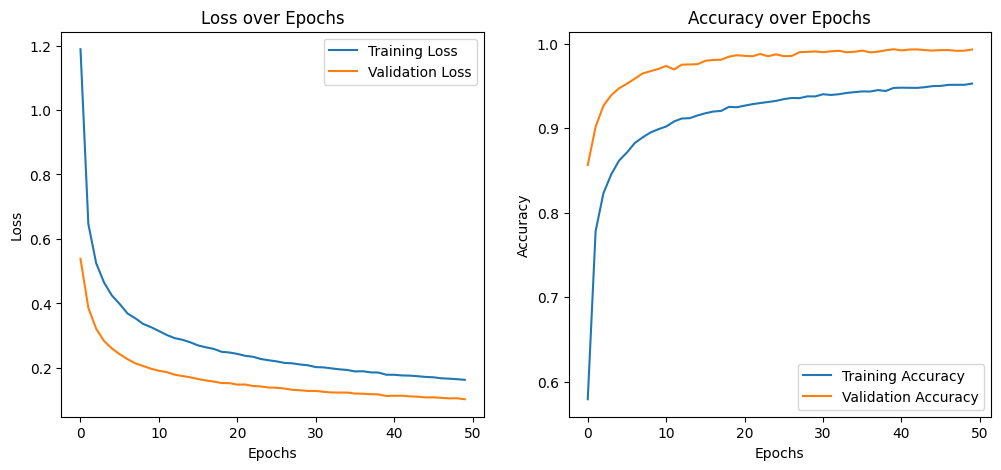

In [77]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss') 
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [78]:
categories = ['R', 'I', 'A', 'S', 'E', 'C']
new_data = np.array([[4,4,4,5,2,2,1,1,4,1,1,4,1,2,1,1,1,1,2,4,4,2,3,5,2,1,1,1,1,1,1,4,2,5,5,1,2,1,4,1,3,4,5,2,3,1,2,4],
                    [3,2,3,4,4,3,4,1,4,5,1,1,3,3,4,3,5,3,2,3,3,3,4,1,2,3,3,1,4,5,2,1,1,3,1,3,1,2,1,3,2,1,4,2,3,3,2,3],
                    [1,4,2,2,1,3,4,3,3,1,2,5,1,2,2,5,1,5,3,3,1,3,3,4,2,5,5,5,3,3,3,1,5,1,5,3,1,1,4,2,3,3,1,3,4,1,4,2],
                    [1,2,2,2,1,3,4,1,1,1,2,5,1,2,2,5,1,1,3,2,1,3,3,2,2,5,5,2,3,3,3,1,5,1,5,3,1,3,4,2,5,4,4,3,5,1,3,2],
                    [2,3,4,5,2,1,1,5,2,3,2,2,3,3,3,1,3,1,1,2,1,5,3,4,5,1,1,5,4,1,1,5,3,3,2,2,4,5,5,2,3,2,2,4,3,3,5,2],
                    [1,2,3,2,1,4,4,1,5,5,3,5,5,2,3,3,1,1,2,2,1,5,2,2,5,4,5,2,3,3,3,2,2,1,3,2,1,3,4,3,1,4,4,1,3,1,2,1],
                    [1,3,1,2,1,2,1,3,2,3,1,1,2,1,2,2,3,1,2,3,2,1,1,2,5,5,5,1,4,4,5,3,1,1,1,5,3,3,5,1,5,4,4,3,5,5,5,5],
                    [2,2,1,2,3,3,2,2,1,3,4,2,2,2,3,2,5,2,1,3,2,5,5,5,1,4,4,5,4,2,5,4,1,1,4,4,2,4,4,3,1,1,1,3,1,2,5,2],
                    [1,4,3,5,4,5,1,1,1,1,5,5,5,5,1,5,5,5,3,5,5,3,1,5,1,3,3,5,2,5,3,5,2,3,1,1,2,3,2,1,2,1,5,4,5,1,3,2],
                    [5,1,2,2,3,2,1,1,3,2,1,1,1,1,5,3,1,3,1,3,2,4,1,5,1,2,5,5,3,4,5,5,1,3,3,4,5,5,1,2,4,2,3,2,5,1,5,3]])


predictions = model.predict(new_data)

max_indices = predictions.argmax(axis=1)
binary_predictions = np.zeros_like(predictions)
binary_predictions[np.arange(len(predictions)), max_indices] = 1

print("Probabilitas Prediksi:\n", predictions)
print("\nHasil Biner:\n", binary_predictions)

print("\nKeterangan Kategori RIASEC:")
for i, binary_result in enumerate(binary_predictions):
    predicted_categories = [categories[j] for j, val in enumerate(binary_result) if val == 1]
    print(f"Data ke-{i+1}: {', '.join(predicted_categories)}")

print("\nGround Truth: C, R/I/A, S, C, E, I, C, S, A, S")

1/1 [==============================] - 0s 81ms/step
Probabilitas Prediksi:
 [[1.7180076e-01 5.0530355e-07 4.6668019e-02 1.1903710e-10 4.6945726e-03
  7.7683610e-01]
 [4.4030657e-01 4.2812485e-01 1.2749897e-01 2.5976129e-05 3.5551799e-04
  3.6880954e-03]
 [2.9475577e-04 2.1879126e-04 1.0772570e-03 9.9786466e-01 3.5101207e-04
  1.9359648e-04]
 [1.4765361e-04 4.5616521e-06 5.6846634e-06 1.0255196e-02 5.7372400e-03
  9.8384976e-01]
 [1.0944476e-02 5.8417871e-05 1.3171390e-04 3.3768879e-03 9.6631938e-01
  1.9169141e-02]
 [1.1342344e-05 9.9998569e-01 1.8664728e-09 9.8652640e-07 2.0398137e-07
  1.8211740e-06]
 [1.7824536e-09 2.2330946e-12 6.3098467e-12 1.3747983e-02 1.0774902e-08
  9.8625201e-01]
 [1.9169276e-05 9.6165595e-06 2.1356438e-01 7.8627843e-01 1.2185529e-04
  6.5707136e-06]
 [8.6974924e-06 2.4109241e-04 9.9974400e-01 2.2048316e-07 2.1208511e-07
  5.7452226e-06]
 [6.6578309e-07 1.5246576e-07 1.3680485e-06 9.9996328e-01 1.2236806e-05
  2.2305749e-05]]

Hasil Biner:
 [[0. 0. 0. 0. 0. 1

In [116]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [117]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)